In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
from tqdm.notebook import tqdm
sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint
import json
from collections import defaultdict
from googletrans import Translator
import time
from datasets import Dataset

In [ ]:
translator = Translator()
def translate_df(df, batch_size=1, translator=translator):
    def translate_text(text, sleep_time=2):
        if text in [''] or text is None:
            return ''
        while True:
            try:
                return translator.translate(text, src="en", dest="vi").text
            except:
                print("Requests error")
                time.sleep(sleep_time)
    
    def clean_text(text):
        return text
    
    data = defaultdict(list)
    for i in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[i : i + batch_size]
        temp_data = defaultdict(list)
        for col in df.columns:
            batch_df[col] = batch_df[col].apply(lambda x: clean_text(x))
            col_vals = ' ## '.join(batch_df[col].values)
            temp_data[col] = [x.strip() for x in translate_text(col_vals).split('##')]

        can_insert_batch = True
        for col in df.columns:
            if len(temp_data[col]) != len(batch_df):
                can_insert_batch = False
                break

        if can_insert_batch:
            for col in df.columns:
                data[col].extend(batch_df[col].values)
                data[f'{col}_translated'].extend(temp_data[col])
            continue
        
        # else loop through each row
        for _, row in batch_df.iterrows():
            for col in df.columns:
                text = clean_text(row[col])
                data[col].append(text)
                data[f'{col}_translated'].append(translate_text(text))
                
    df = pd.DataFrame(data)
    return df.drop(columns=[col for col in df.columns if '_translated' not in col]) 

In [ ]:
a = """Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] {prompt}
[|AI|] {response}
[|Con người|]"""

def get_prompt(row):
    return a.format(prompt=row['prompt'], response=row['response'])

In [ ]:
temp = pd.read_json('../../data/translated/vi_alpaca_reduced.jsonl', lines=True)
temp2 = temp.apply(lambda x: get_prompt(x), axis=1)
temp2 = pd.DataFrame(temp2)
temp2.columns = ['prompt']

In [ ]:
temp3 = pd.read_json('../../data/translated/quora_chat_data_translated.json', orient='records')

In [ ]:
temp3.to_json('../../data/translated/quora_chat_data_translated.json',lines=True,orient='records')
temp2.to_json('../../data/translated/alpaca_chat_cleaned_translated.json',lines=True,orient='records')

## Clean ShareGPT

In [ ]:
share_gpt = pd.read_json('../../data/original/ShareGPT_V3_unfiltered_cleaned_split.json')

In [ ]:
popular_programming_keywords = [
    "python",
    "java",
    "javascript",
    "c#",
    "c++",
    "typescript",
    "ruby",
    "swift",
    "kotlin",
    "php",
    "rust",
    "scala",
    "dart",
    "matlab",
    "objective-c",
    "perl",
    "lua",
    "assert",
    "async",
    "await",
    "def",
    "elif",
    "lambda",
    "nonlocal",
    "function",
    "var",
    "cuda",
    "torch",
    "code",
    "sudo",
    "bash"
]
popular_programming_languages = [
    "python",
    "java",
    "javascript",
    "typescript",
    "kotlin",
    "objective-c",
]
def check_text_not_contain_code(text):
    temp2 = text.lower()
    temp = set(temp2.split())
    for language in popular_programming_keywords:
        if language in temp:
            return False
    for language in popular_programming_languages:
        if language in temp2:
            return False
    return True

temp = share_gpt['conversations'].apply(lambda x: str(x)).apply(check_text_not_contain_code)


In [ ]:
share_gpt_no_code = share_gpt[temp][['conversations']]
share_gpt_no_code = share_gpt_no_code[share_gpt_no_code['conversations'].apply(lambda x: len(x) >= 4)]
share_gpt_no_code.shape

In [ ]:
from numpy import nan


def create_conversation(turns):
    res = "The conversation between human and AI assistant.\n"
    for turn in turns:
        if turn['from'] == 'human':
            res += "[|Human|] " + turn['value'] + "\n"
        elif turn['from'] == 'gpt':
            res += "[|AI|] " + turn['value'] + "\n"
        else:
            return nan
    return res

share_gpt_no_code_conversations = share_gpt_no_code.apply(lambda x: create_conversation(x['conversations']), axis=1)

In [ ]:
print(share_gpt_no_code_conversations.sample(1).iloc[0])

In [ ]:
share_gpt_no_code_conversations.to_json('../../data/original/share_gpt_no_code_conversations.json', orient='records', lines=True)

## FAQ

In [342]:
path = '../../data/translated/all_faqs.json'
faqs = pd.read_json(path)

In [343]:
faqs

,instruction,input,output
0,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Tội giết con mới đẻ là gì?\nĐiều luật...,Người mẹ nào do ảnh hưởng nặng nề của tư tưởng...
1,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Vì làm ăn thiếu vốn nên em có vay của...,Bộ luật Hình sự quy định về tội lừa đảo chiếm ...
2,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,"Câu hỏi: Theo quy định pháp luật, trường hợp n...",Theo quy định tại khoản 1 Điều 6 Thông tư số 1...
3,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Chủ thể chịu trách nhiệm hình sự đối ...,Chủ thể của tội làm giả hồ sơ để tiêm vaccine ...
4,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Tội khai báo gian dối hoặc cung cấp t...,"Tại Điều 382, Bộ luật Hình sự năm 2015 sửa đổi..."
...,...,...,...
6695,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Hỗ trợ doanh nghiệp vay vốn trả lương...,1. Điều kiện hỗ trợ doanh nghiệp vay vốn trả l...
6696,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Tôi muốn thành lập chi nhánh doanh ng...,Có. Theo quy định tại Điều 29 Luật đấu giá tài...
6697,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Hành vi đánh nhau có hung khí\nĐiều l...,"Theo Điều 7 Nghị định 144/2021/NĐ-CP, hành vi ..."
6698,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Người làm việc theo hợp đồng lao động...,Theo quy định tại khoản 2 Điều 2 của Thông tư ...


In [338]:
template = """{instruction}\n{input}\nCâu trả lời: {output}"""
print(template.format(**faqs.sample(1).iloc[0]))

Bạn là luật sư. Hãy trả lời câu hỏi pháp luật dựa vào những điều luật được trích dẫn dưới đây. Nếu không tìm có câu trả lời thì trả lời là tôi không biết.
Câu hỏi: Quy định về việc giao nhà khi cho thuê như thế nào?
Điều luật liên quan: 
Câu trả lời: – Bên cho thuê phải giao tài sản cho bên thuê đúng số lượng, chất lượng, chủng loại, tình trạng, thời điểm, địa điểm đã thoả thuận và cung cấp thông tin cần thiết về việc sử dụng tài sản đó. – Trường hợp bên cho thuê chậm giao tài sản thì bên thuê có thể gia hạn giao tài sản hoặc hủy bỏ hợp đồng và yêu cầu bồi thường thiệt hại; nếu tài sản thuê không đúng chất lượng như thoả thuận thì bên thuê có quyền yêu cầu bên cho thuê sửa chữa, giảm giá thuê hoặc hủy bỏ hợp đồng và yêu cầu bồi thường thiệt hại.


In [340]:
temp = faqs['input'].apply(lambda x: not x.endswith('Điều luật liên quan: '))
faqs = faqs[temp]

In [341]:
faqs

,instruction,input,output
1,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Vì làm ăn thiếu vốn nên em có vay của...,Bộ luật Hình sự quy định về tội lừa đảo chiếm ...
6,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Thẩm quyền giải quyết tranh chấp đất ...,Giải quyết tranh chấp đất đai là hoạt động của...
8,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Nhiệm vụ quyền hạn của Uỷ ban nhân xã...,Theo quy định tại Điều 115 Luật Tổ chức Hội đồ...
15,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,"Câu hỏi: Chào anh/chị, Về việc xin cấp Phiếu l...",Chào bạn Nguyen Vu Cuong! Trung tâm Lý lịch tư...
16,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Tôi có 120m2 đất được hưởng từ di chú...,"Trường hợp bạn hỏi, chúng tôi xin được trả lời..."
...,...,...,...
6689,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Hành vi gian lận bảo hiểm y tế bị xử ...,1. Căn cứ Điều 215 Bộ luật Hình sự 2015 quy đị...
6690,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Đơn xin nghỉ việc phải gửi trước bao ...,Theo quy định tại Điều 35 Bộ luật Lao động năm...
6691,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Tội cướp giật tài sản được coi là hoà...,Tội cướp giật tài sản hiện nay được quy định t...
6693,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,"Câu hỏi: Vừa qua, tôi có yêu cầu Sở Tư pháp nơ...",Theo quy định tại khoản 3 Điều 42 Luật Lý lịch...


In [273]:
faqs['output_len'] = faqs['output'].apply(lambda x: len(x.split()))

<AxesSubplot:>

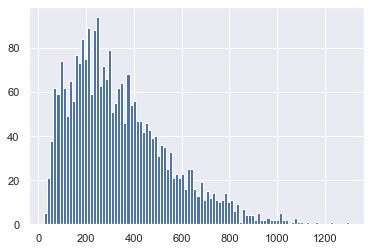

In [274]:
faqs['output_len'].hist(bins=100)

In [283]:
faqs_standard = faqs[faqs['output_len'] < 200]

In [310]:
template = """{instruction}\n{input}\nCâu trả lời: {output}"""
print(template.format(**faqs_standard.sample(1).iloc[0]))

Bạn là luật sư. Hãy trả lời câu hỏi pháp luật dựa vào những điều luật được trích dẫn dưới đây. Nếu không tìm có câu trả lời thì trả lời là tôi không biết.
Câu hỏi: Điều kiện nhận thừa kế quyền sử dụng đất?
Điều luật liên quan: Điều 188. Điều kiện thực hiện các quyền chuyển đổi, chuyển nhượng, cho thuê, cho thuê lại, thừa kế, tặng cho, thế chấp quyền sử dụng đất; góp vốn bằng quyền sử dụng đất 1. Người sử dụng đất được thực hiện các quyền chuyển đổi, chuyển nhượng, cho thuê, cho thuê lại, thừa kế, tặng cho, thế chấp quyền sử dụng đất; góp vốn bằng quyền sử dụng đất khi có các điều kiện sau đây: a) Có Giấy chứng nhận, trừ trường hợp quy định tại khoản 3 Điều 186 và trường hợp nhận thừa kế quy định tại khoản 1 Điều 168 của Luật này; b) Đất không có tranh chấp; c) Quyền sử dụng đất không bị kê biên để bảo đảm thi hành án; d) Trong thời hạn sử dụng đất. 2. Ngoài các điều kiện quy định tại khoản 1 Điều này, người sử dụng đất khi thực hiện các quyền chuyển đổi, chuyển nhượng, cho thuê, cho th

In [333]:
template = """{instruction}\n{input}\nCâu trả lời: {output}"""
print(template.format(**faqs.sample(1).iloc[0]))

Bạn là luật sư. Hãy trả lời câu hỏi pháp luật dựa vào những điều luật được trích dẫn dưới đây. Nếu không tìm có câu trả lời thì trả lời là tôi không biết.
Câu hỏi: Những trường hợp không được tha tù trước thời hạn?
Điều luật liên quan: Điều 66. Tha tù trước thời hạn có điều kiện 1. Người đang chấp hành án phạt tù về tội phạm nghiêm trọng, tội phạm rất nghiêm trọng hoặc tội phạm đặc biệt nghiêm trọng mà đã được giảm thời hạn chấp hành án phạt tù hoặc người đang chấp hành án phạt tù về tội phạm ít nghiêm trọng có thể được tha tù trước thời hạn khi có đủ các điều kiện sau đây: a) Phạm tội lần đầu; b) Có nhiều tiến bộ, có ý thức cải tạo tốt; c) Có nơi cư trú rõ ràng; d) Đã chấp hành xong hình phạt bổ sung là hình phạt tiền, nghĩa vụ bồi thường thiệt hại và án phí; đ) Đã chấp hành được ít nhất là một phần hai mức phạt tù có thời hạn hoặc ít nhất là 15 năm đối với trường hợp bị phạt tù chung thân nhưng đã được giảm xuống tù có thời hạn. Trường hợp người phạm tội là người có công với cách mạn

In [339]:
faqs_standard

,instruction,input,output,output_len
16,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Tôi có 120m2 đất được hưởng từ di chú...,"Trường hợp bạn hỏi, chúng tôi xin được trả lời...",184
38,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Vay tiền nhưng không trả có thể bị tr...,Vay tiền nhưng không trả có thể bị truy cứu tr...,56
46,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Trước đây ngõ đi nhà tôi đi một m...,Theo khoản 1 Điều 2 Luật Khiếu nại: Khiếu nạ i...,172
48,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Quy định về số ngày nghỉ hằng tuần củ...,Theo quy định tại Điều 111 Bộ Luật Lao động 20...,199
52,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Quy định về xoá kỷ luật lao động tại ...,Theo quy định tại Điều 126 Bộ luật lao động 20...,129
...,...,...,...,...
6676,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,"Câu hỏi: Trong hoạt động chứng thực, người thự...",Điều 12 Nghị định 79/2007/NĐ-CP thì người thực...,180
6679,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Phòng vệ chính đáng là gì?\nĐiều luật...,Căn cứ theo Điều 22 Bộ luật hình sự 2015 quy đ...,140
6681,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Có ký lại hợp đồng lao động mới khi h...,Căn cứ theo khoản 1 Điều 10 Nghị định 145/2020...,81
6683,Bạn là luật sư. Hãy trả lời câu hỏi pháp luật ...,Câu hỏi: Đầu cơ tích trữ xăng dầu bị xử phạt n...,Về hình thức xử lý hành chính Theo khoản 4 Điề...,144


In [7]:
temp = Dataset.from_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/training/alpaca_chat_cleaned_51k_translated.json')
temp.rename_column(temp.column_names[0], 'text')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-d3abced93aecb5f3/0.0.0)


Dataset({
    features: ['text'],
    num_rows: 51092
})

In [2]:
ds = Dataset.from_json('../../data/original/gpt4-instruct-similarity-0.8-dataset.json')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/phamhoang1408/.cache/huggingface/datasets/json/default-23f6ad8c7fb0fd01/0.0.0. Subsequent calls will reuse this data.


In [126]:
len(ds.shuffle()[0]['response'].split())

73

In [127]:
ds

Dataset({
    features: ['instruction', 'input', 'response'],
    num_rows: 17842
})

In [2]:
from datasets import Dataset, concatenate_datasets
from glob import glob

def load_dataset(folder_path, dataset_size=None):
    data = []
    file_paths = glob(folder_path + "/*.jsonl")
    for path in file_paths:
        ds = Dataset.from_json(path)
        if len(ds.column_names) != 1:
            raise ValueError("Dataset must have only one text column")
        ds = ds.rename_column(ds.column_names[0], "text")
        data.append(ds)
    if dataset_size is None:
        return concatenate_datasets(data, axis=0).shuffle()
    return concatenate_datasets(data, axis=0).shuffle().select(range(dataset_size))

In [4]:
ds = load_dataset('../../data/training_31_7')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-bdcba7b726f115e8/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-dc649acb2e7235cf/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-147a908678ebab1a/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-5edb312ba78e68c9/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3a54ee1ab9c82871/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-63cdd11bf4d5b52d/0.0.0)


In [64]:
print(ds.shuffle()[0]['text'])

Tóm tắt ngắn gọn đoạn hội thoại sau:
[|Con người|] Ali! Có chuyện gì vậy? Bạn không thể thức dậy sáng nay?
[|AI|] Đêm qua tôi thức khuya. Bạn tôi đã có một bữa tiệc. Tôi chỉ ngủ khoảng bốn giờ.
[|Con người|] Sao sáng nay bạn không nằm trên giường?
[|AI|] Tôi phải gặp nhóm học của mình ở thư viện. Chúng tôi có một văn bản lớn vào tuần tới.
[|Con người|] Một văn bản lớn? Tại sao bạn không học tối qua thay vì đi dự tiệc?
[|AI|] Ồ, không sao đâu. Tôi đã nghiên cứu rất nhiều trước bữa tiệc.
[|Con người|] Có lẽ đó không phải là ý kiến ​​hay. Tôi đã đọc một báo cáo. Nó nói rằng nếu bạn không ngủ đủ giấc sau khi học, bạn có thể quên 30% những gì bạn đã học!
Hội thoại sau khi được tóm tắt:
Tối qua Ali thức khuya và sáng nay phải họp nhóm học nên Ali không ngủ đủ giấc.
